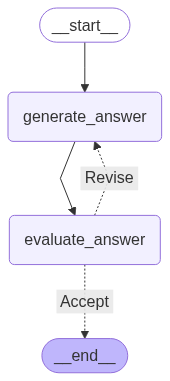


🎯 Final Answer:
 <think>
Okay, I need to answer the interview question 'Tell me about a time you led a team project' using the STAR method. I'm a bit new to this, so I'll take it step by step.

First, I should remember what STAR stands for: Situation, Task, Action, Result. Each part needs to be covered clearly.

Starting with the Situation. I should set the context. Maybe I can talk about when I was in a marketing role and led a campaign. I need to make it specific, like the goal was to increase brand awareness for a new product launch.

Next is the Task. What was my responsibility? I was leading a cross-functional team, which included people from different departments like creative, sales, and product. My main task was to plan and execute the campaign within a tight timeline, maybe 8 weeks, and a budget of $X.

Now, the Action part. I need to detail what I did. I should mention how I started by setting clear objectives and delegating tasks based on everyone's strengths. Maybe I organ

In [2]:
import os
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Literal, TypedDict
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

# Load environment variables
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Initialize LLM
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

# Define the state used by the graph
class State(TypedDict):
    topic: str  # Interview question
    answer: str
    feedback: str
    evaluation: str  # "strong" or "weak"

# Define structured schema for evaluation
class Evaluation(BaseModel):
    grade: Literal["strong", "weak"] = Field(description="Is the answer strong or weak?")
    feedback: str = Field(description="Constructive feedback if the answer is weak.")

# Structured evaluator
evaluator = llm.with_structured_output(Evaluation)

# Node: Generate Answer
def generate_answer(state: State):
    prompt = f"Answer the interview question '{state['topic']}' using the STAR method."
    if state.get("feedback"):
        prompt += f" Consider this feedback: {state['feedback']}"
    msg = llm.invoke(prompt)
    return {"answer": msg.content}

# Node: Evaluate Answer
def evaluate_answer(state: State):
    eval_result = evaluator.invoke(
        f"Evaluate this interview answer using STAR format:\nQuestion: {state['topic']}\nAnswer: {state['answer']}"
    )
    return {"evaluation": eval_result.grade, "feedback": eval_result.feedback}

# Conditional routing
def route(state: State):
    return "Accept" if state["evaluation"] == "strong" else "Revise"

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_answer", generate_answer)
builder.add_node("evaluate_answer", evaluate_answer)

builder.add_edge(START, "generate_answer")
builder.add_edge("generate_answer", "evaluate_answer")

builder.add_conditional_edges(
    "evaluate_answer",
    route,
    {
        "Accept": END,
        "Revise": "generate_answer",
    },
)

# Compile workflow
workflow = builder.compile()

# Visualize graph (only in Jupyter)
display(Image(workflow.get_graph().draw_mermaid_png()))

# Run workflow
initial_input = {"topic": "Tell me about a time you led a team project."}
final_state = workflow.invoke(initial_input)

print("\n🎯 Final Answer:\n", final_state["answer"])
